# Time Series Forecasting Project
In this workbook you build a model to forecast the price of a Stock - don't get too excited, you probably won't get rich with this model.

We will take data from a Yahoo webservice for a stock of your choice and attempt to predict the Closing Price.

As this is a Project, the workbook only gives you a skelton to work with, how you decide to solve this is up to you. No doubt you will want to refer back to previous exercises to find code snipets you can copy and adapt to this purpose.

## Important
This exercise is not meant to be straightforward, you will be given some skeleton code but you will need to create much of the model yourself and make more descisons about design and training your model.

In part it is to consolidate your knowledge but also to expose you to the often iterative nature of building and training models.

We usually allocate about 1hr to this exercise so you have plenty of time to experiment with different options in a group and iternative manner, you should have time to fully train a few different models.

Don't Panic - this is not a test so if you need assistance or guidance just ask.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import pandas_datareader.data as data
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

2.0.0-beta1


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [2]:
# Useful functions
def print_timeseries(generator, num_samples=0):
    pairs = len(generator[0][0])
    if (num_samples > 0 and num_samples < pairs ):
        pairs = num_samples
    
    for i in range(pairs):
        x = generator[0][0][i]
        
        y = generator[0][1][i]
        
        print("[%s] => [%s]" % (x, y))

def create_target_series_for_generator(data, skip_output=0, output_length=1):
    # The Generator will deal selecting the next in the sequence
    # but if our predictions are skiping steps we need to shift our data a bit
    shifted_data = data[skip_output:]
   
    # Now we loop through this shifted data set and collect sucessive  pairs
    # and add them to our target_seq
    target_seq = []
    # Stop before we run out of output groups
    pairs = len(shifted_data) - output_length
    for i in range(pairs):
        item = []
        for j in range(output_length):
            item.append(shifted_data[i+j])
        target_seq.append(item)
    return target_seq

def printLoss(history):
    history_dict = history.history
    loss = history_dict['loss']
    epochs = range(1, len(loss) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def get_y_from_generator(generator):
    y = None
    for i in range(len(generator)):
        batch_y = generator[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    
    return y

## Get the data
The data we are using contains monthly figures for the number of Passengers (in thousands) and the Mean Monthly Temperature for the associated Month.

For this workbook we will only be working with the number of Passengers

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 1)

# We are using the Apple stock price but feel free to pick a different one.
dataset = data.DataReader("AAPL", "yahoo", start, end)
dataset.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


### Plotting the data
The following cell plots a graph showing the number of Passengers travelling per month and the mean temperature for the month over a 12 year period.

You can see from the graph that the data shows:
- A general upward trend with each each of data being higher than the last
- A seasonality to the data where each year has a similar shape but differs in the ranges of values

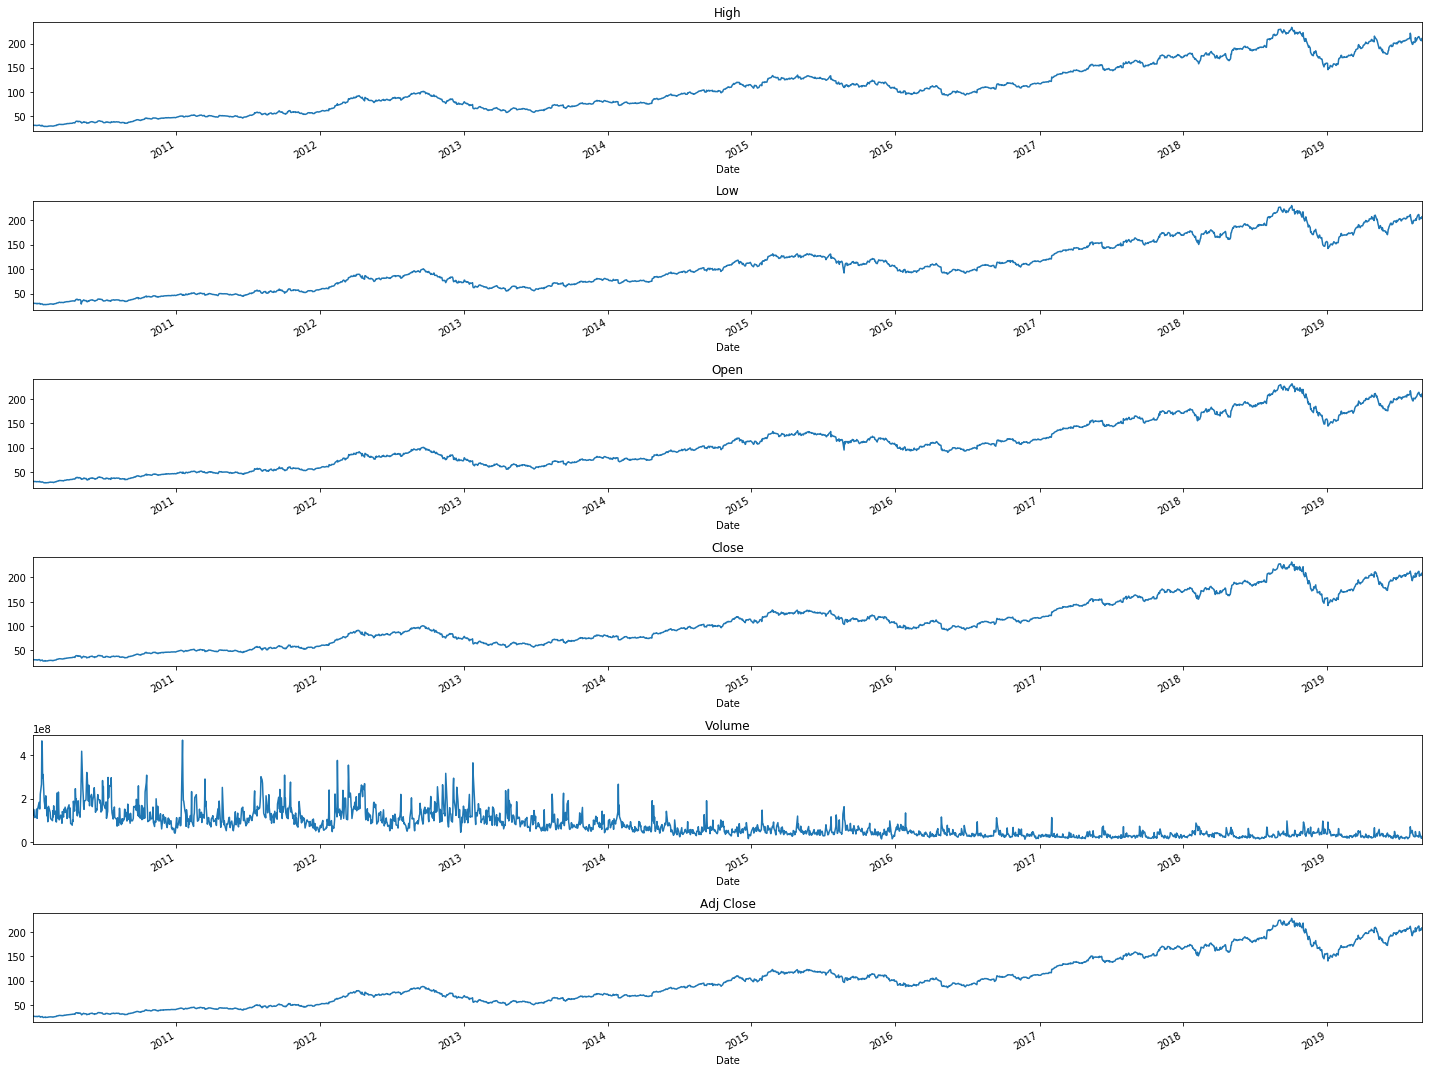

In [4]:
fig,ax = plt.subplots(6,1,figsize=(20,15))
for i,column in enumerate([col for col in dataset.columns]):
    dataset[column].plot(ax=ax[i])
    ax[i].set_title(column)
fig.tight_layout()

# Prepare your data
We have a lot of data in this dataset both in terms of the number of samples in the time series but also we have 6 time series.

When building this model you need to decide whether you will work with a single time series or multiple time-series to predict the Share __Close__ price.

## Exercise
Decide which time-series you want to use for your training samples and remove the others from the dataset.

In [5]:
features_to_drop = ['Volume', 'Adj Close']
dataset.drop(features_to_drop, axis=1, inplace=True)
dataset.head()

,High,Low,Open,Close
Date,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857
2010-01-05,30.798571,30.464285,30.657143,30.625713
2010-01-06,30.747143,30.107143,30.625713,30.138571
2010-01-07,30.285715,29.864286,30.250000,30.082857
2010-01-08,30.285715,29.865715,30.042856,30.282858


## Prepare our data
We now need to prepare our data and create a TimeseriesGenerator to work with. 

In this workbook we are only looking to predict the passenger levels for the next month given the previous few months of data.

### Normalise our data
As before we need to normalise our data so that our values are in the range 0-1 to help learning

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(dataset)

print(dataset.shape)

(2432, 4)


We will use TimeseriesGenerators but before we create them we need to split our data into Training and Testing sets.

### Exercise
Look at the graph above, at what point should we make the split?

If you rememebr from the previous workbook we want our Testing set to contain any Seasonality and Trends present in our Training data. Additionally, we usually take Testing data from the most recent data.

Set the value below to make the split - we have just over2400 data point so a number that is about 80% of the way through is probably suitable

In [11]:
testing_data_after = 2000

train_data = data[:testing_data_after]
test_data = data[testing_data_after:]

print(train_data.shape)


(2000, 4)


We need to create our target data as we are trying to predict passenger numbers whereas our data contains passenger numbers and temperature.

In [13]:
close_col_index = 2

train_target = train_data[:,close_col_index]
test_target = test_data[:,close_col_index]

In [16]:
num_series = train_data.shape[1]
print(num_series)

4


Next we need to create our TimeseriesGenerators for training and testing. In this workbook we are only predicing the next data point ahead but we need to decide on how many historical data points we will use to forecast ahead. Each data point represents a 1 hour slot

### Exercise
We have a lot of data points so how many data points should we use? 4? 6? 12?
In the next cell you can specify the number of months to use as features in your model.

In [14]:
# TODO: Specify the number of days you want to use as your features
feature_lookback = 5


# Create our TimeseriesGenerator for Training
training_generator = TimeseriesGenerator (data = train_data,
                                    targets = train_target,
                                    length = feature_lookback)

# Create our TimeseriesGenerator for Testing
testing_generator = TimeseriesGenerator (data = test_data,
                                    targets = test_target,
                                    length = feature_lookback)

# Build our Model
We are now in a position to design our model using your own choice of networks architecture. We will provide a skeleton for you but it will be up to you to complete the model and train it.

## Exercise
Work in your groups to decide what network archiecture you will use and each train a different network to compare the results.

Some options include:
 - Create a network consisting of a series of Dense layers
 - Create a network using a series of CNN layers
 - Create a network using an LSTM

We have provided you with starter code for each of the 3 options. You should complete the cell for the model you are building and only run that cell. 

Each Cell has been set to be a _Markup_ cell so you will need to change the cell type on the one you are building to be _Code_. 

Ask if you are not sure how to do this

In [17]:
# Multi-Level Network using Dense Nodes

model = tf.keras.Sequential()

# Input Layer
model.add(keras.layers.Input(shape=(feature_lookback, num_series)))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Flatten())

# Hidden Layers
# TODO: Add one or more hidden layers
model.add(keras.layers.Dense(units=128, activation='relu'))


# Output Layer
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer='adam')

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5, 128)            640       
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               82048     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 82,817
Trainable params: 82,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# CNN Network
model = keras.Sequential()

# Input Layer
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', 
                     input_shape=[feature_lookback, num_series]))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# Hidden Layers
model.add(keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))



# Output Layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer='adam')

model.summary()


In [ ]:
# LSTM Network
model = tf.keras.models.Sequential()

# TODO: Specify the number of units you want your LSTM
model.add(keras.layers.LSTM(units = 50, input_shape=(feature_lookback, num_series)))

# TODO: Optionally add one or more Dense or Convolutional layers
model.add(keras.layers.Dense(128))
model.add(keras.layers.Dense(128))

# Output layer
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.summary()

# Train your model

In [18]:
# We'll train for some epochs
max_epochs = 10

# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train our model
history = model.fit_generator(training_generator, epochs = max_epochs,
                   callbacks=[early_stop])

Epoch 1/10
16/16 [==============================] - 1s 65ms/step - loss: 0.0278
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 4.5227e-04
Epoch 4/10
16/16 [==============================] - 0s 8ms/step - loss: 1.4724e-04
Epoch 5/10
16/16 [==============================] - 0s 8ms/step - loss: 1.0024e-04
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 8.7308e-05
Epoch 7/10
16/16 [==============================] - 0s 10ms/step - loss: 8.8585e-05
Epoch 8/10
16/16 [==============================] - 0s 8ms/step - loss: 9.0336e-05
Epoch 9/10
16/16 [==============================] - 0s 11ms/step - loss: 8.2378e-05
Epoch 10/10
16/16 [==============================] - 0s 9ms/step - loss: 7.9064e-05


# Evaluate your model
With the model trained we can evaluate the model against our training data.

__Note__: We only have 144 data points so our models are probably not going to be that accurate.

## Exercise
Look at the plot of the model loss during training; if the curve has shallowed out and not changing much then the model has probably reached it's limit of learning. If not continue to train the model for more epochs.


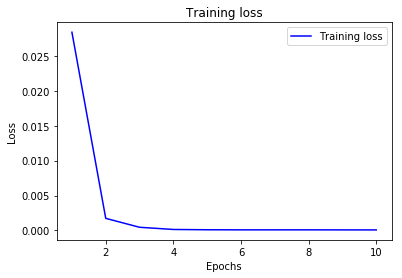

In [19]:
printLoss(history)

## Exercise
We can now run our model against the previously unseen error and get a measure of how good the model is (Mean Squared Error). 

While this may look small we have to remember that we normalised the data to the range 0-1

In [20]:
# Evaluate
model.evaluate_generator(testing_generator)

0.00036976727278670296

# Comparing Predicted and Actual forecast
Let's now plot our predicted values against the actual values.

Before we can do this we need to extract some values from our testing generator

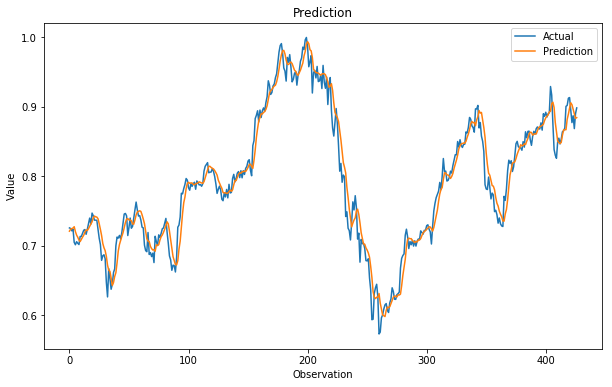

In [21]:
# Make predictions
y_pred_test = model.predict(testing_generator)
y_actual = get_y_from_generator(testing_generator)


# Plot graph of predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred_test, label='Prediction')
plt.title("Prediction")
plt.xlabel('Observation')
plt.ylabel('Value')
plt.legend()
plt.show();